In [10]:
#1 HOG Feature model train
#kütüphanleri yükledik
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#HOG Feature model oluşturma
#hog feature model parametrelerini oluşturduk
FeatureVecSize = 7056; #train edilicek resimlerin hog shape i
winSize = (60,60)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (4,4)
nbins = 9

#resimlerin dosya yolunu belirttik

dir='dataset/trainingData'
categories=[]

#resimlerin dosya isimleri için for döngüsü oluşturduk "1,2,3,4,.."
for i in range (59):
    categories.append("{}".format(i))

    
categories.remove('0')
    
#hog feature hesaplama metodunu oluşturduk
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
#train edilicek data için array oluşturduk train edilicek datayı yatay bir array haline getirdik 
trainData = np.zeros((1, FeatureVecSize), dtype = "float32")
#labellama için array oluşturduk
labels = np.zeros((1, 1), dtype = "float32")
for category in categories:
    #dosya yolundan resimleri aktarmak için bir path belirledik
    path=os.path.join(dir,category)
    #categories listesindeki öğeleri indekslerine göre labelladık
    label=categories.index(category)
    
    for img in os.listdir(path):
        #belirtilen yoldaki resimleri açtık
        imgpath = os.path.join(path,img)
        obj_img = cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE)
        try:
            #hog feature hesaplattık
            hog_array = hog.compute(obj_img)
            #hog hesaplatılan datayı yatay hale getirdik
            out = (hog_array).reshape(-1,FeatureVecSize)
            #trainData ve labels arraylerine datayı ve labelları ekledik
            trainData = np.float32( np.insert(trainData, -1, out, 0)) 
            labels = np.float32( np.insert(labels, -1, label, 0))
        #hata aldığımızda işleme devam etmesi için except ve try döngülerini kullandık    
        except Exception as e:
            pass


In [12]:
#2 SVM Classifier Model Oluşturma:

x_train,x_test,y_train,y_test = train_test_split(trainData,labels,test_size=0.2)

model = SVC(C=15,kernel='rbf',gamma='auto')

model.fit(x_train,y_train)


D:\Okul\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=15, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy:  0.8911174785100286
Predict:  o


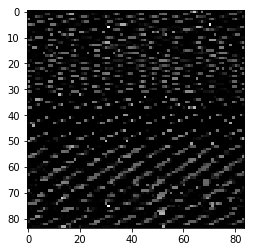

In [13]:
#Model Doğruluğunu test etme

#labellanmış train data üzerinden yaptığı tahminin denk geldiği harfi görmek için tahminlenicek öğelerin olduğu liste yaptık
ayirici='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,;:?!.'
categories=[]
for i in ayirici:
    categories.append(i)
#tahminleme ve doğruluk oranı hesaplattık
prediction=model.predict(x_test)
accuracy=model.score(x_test,y_test)

print('Accuracy: ',accuracy)
print('Predict: ',categories[int(prediction[0])])

ornek=x_test[0].reshape(84,84)
plt.imshow(ornek,cmap='gray')
plt.show()

In [9]:
#4 Kelimeleri ayırma

#read image
img = cv2.imread('text.jpg')

#grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = cv2.blur(gray,(5,5))

#binarize 
ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)

#find contours
im2,ctrs, hier = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1] )

#roi için bound box ların parametlerinin ek değerleri
s=10
sm=-5
sayac=0

for i, ctr in enumerate(sorted_ctrs):
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)
    #y ve height değerlerini manipüle ettik böylece harfleri teker teker alabildi
    w += s
    h += 25
    x += sm
    y += -20
    
    # Getting ROI
    #bulduğu her harfi png olarak kayıt edicek
    #kontör sayısına göre harfleri ayırdık böylece 'i' harflerinin noktalarını almamış olduk
    if len(ctr)>20:
        sayac=int(sayac)
        sayac+=1
        sayac=str(sayac)
        roi = img[y:y+h, x:x+w]
        dir='dataset/exampleimgs1'
        path=os.path.join(dir,sayac)
        cv2.imwrite('{}.png'.format(path), roi)

    
cv2.imshow('binarize',thresh)
cv2.imshow('marked areas',img)
cv2.waitKey(0)

-1

In [14]:
#5 Tahminleme ve yazdırma
ayirici='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,;:?!.'

categories=[]
for i in ayirici:
    categories.append(i)

sayac=int(sayac)
tahmin_liste=[]

for i in range(sayac):
    indeks=str(i+1)
    img = cv2.imread('dataset/exampleimgs/{}.png'.format(indeks),cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img,(60,60))
    imgList = np.zeros((1, 7056), dtype = "float32")
    hog_array_img = hog.compute(img)
    out_img = (hog_array_img).reshape(-1,FeatureVecSize)
    imgList = np.float32( np.insert(imgList, -1, out_img, 0))
    prediction=model.predict(imgList)
    tahmin_liste.append(categories[int(prediction[0])])

    

print(tahmin_liste)


['i', 't', 'i', 'g', 'i', 'h', 't', 'h', '.', 'g', 'c', 'a', 'h', 'm', 'i', 't', 'a', 'b', 'a', 'f', 'c', 'b', 'a', 'v', 't', 'i', 'h', 'c', 'a', 'a', 'b', 't', 'b', 'b', 'h', '.', 'a', 'M', 't', 'f', 'a', 'u', 'a', 'd', 't', 'a', 'h', 'b', 'i', 'c', 'h', 'g', 'd', 't', 'u', 'h', 't', 'u', 'i', '?', 't', 'i', 'g', 'b', 'c', 'c', 'g', 'a', 'a', 'u', 'c', 'c', 'i', 'h', 'h', 'h', 'J', 'a', 't', 'r', 'u', 'd', 'a', 'n', 'y', 'i', '.', 'i', 'b', '.', 'h', 'h', 'V', 'w', 'a', 't', 'b', 'h', 'a', 'i', 'i', 'f', 'M', 'u', 't', 'g', 't', ';', 'f', 'a', 'h', ';', 'r', ';', 'i', 't', 'd', 'i', 'b', ';', '.', 'c', 'i', 'i', 't', ';', 'f', 'h', 'i', ';', '.', 'i', 'i', 'a', 'i', 'a', 'g', 'h', '.', 'g', 'a', 'b', 'h', 'h', 'h', 'h', 'a', 'g', '.', 'c', 'i', 't', 'd', 'g', 'f', 'i', 't', 'c', 't', 'g', ',', 'a', 'u', 'c', 'h', 'c', 'i', 'd', 'u', 'c', 'b', 'y', 'B', 'b', '.', 'a', 'M', ';', '?', 'h', '.', 'a', 'c', 'h', 'a', 'u', 'i', 'a', 't', 'a', 'a', '.', 'h', 'u', 'b', 'h', 'c', 'i', 'b', 'r',

In [18]:
print(tahmin_liste[204:235])

['a', 'u', 'r', 'i', '.', 'h', 'g', 'y', 'c', 'g', 'a', 'a', 'h', 'h', 'c', ';', 't', 'g', 'M', 't', 'i', 't', 'V', 'i', 'h', 'd', 'V', 'M', 'h', 'd', 'c']


In [19]:
metin=''
for i in tahmin_liste:
    metin+=i
print(metin)    

itigihth.gcahmitabafcbavtihcaabtbbh.aMtfauadtahbichgdtuhtui?tigbccgaauccihhhJatrudanyi.ib.hhVwatbhaiifMutgt;fah;r;itdib;.ciit;fhi;.iiaiagh.gabhhhhag.citdgfitctg,auchciducbyBb.aM;?h.achauiataa.hubhcibriitgauri.hgycgaahhc;tgMtitVihdVMhdcaci;dbimwgibfbhhv.gbaicJaid.tbcd.hdahhg?.id?cighigMd..ihahiathcbttiuuuyt;afug;ig;y,jcp;hfiad;iihiah;uci;tgfibcahaihaggiiththchr.yaayciiydicb;hhd;da;cichmachVgdtdigihiaaa;amaMcfckg;h;iautaib.hic.bfagdhin;aitucadidtcwg.h.aaghhaifJid;d;cut.i.iuhhh;aa;aiiwcaii:tiatau:iditdhdgtiacitcythgccifctd.;iit.hgiac;fghhhitduEbdaiciiaicabhidchgia;uch.ai.dTh.ctrt.thmcFhaddv..gtdf;agacad.;it;taithi.h?mR.hicciitxdtta.gciahaggh.ahhdHMacad;tihc;at;hi;Vhdi;aac.iag.ciihcddh?Tg.at;tgiaiaiiddidf;adcbffb;mri.;hb.bhdt;a;ghiTahiaiidbhiah;iahighhhttccabh..ad.duaribEwtc;hiti.fhcihdic;cithtdggaitgttathidkghidd,hthaf;a.aicdagcdacuhatthdhidai.aidabht;rhmdhu.gmhVct?citgadichaah;it;trtEikiidafdccatabadhatidfidadhhrchhautddhf;abifddcdgiihdiith.aygtigunig,bcd;ihg
